In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

### ***Preprocessing***

In [2]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [3]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [4]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_12344/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [6]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [7]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,4681.747790,1122.139662
1994-01-10,3440.58,4653.269355,1080.347860
1994-01-11,3413.77,5433.706888,1082.095245
1994-01-12,3372.02,4927.120792,1083.639265
1994-01-13,3360.01,4216.958605,1067.146255


### ***Adfuller test on FTSE market values***

In [8]:
adfuller(df_market_value_train.market_value.values)

(-1.904935638502626,
 0.32974280493188823,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54856.46568853504)

### ***Observation***
- By observing adfuller test on FTSE values it is clear that FTSE score is not stationary.
- Since p value is 32% which greater than threshold value of 1% 5% and 10%.
- So we should not rely on AR model Cause AR model good modeling stationary series.

### Stratagy to Deal with non stationary Ftse market index values.
- Instead of directly using market price values we can use differnece of two consecutive price values. which is called return in finance domain.
- this return column will be calculated by following formula.
- return = (X(t)-X(t-1)) / X(t-1)

In [14]:
df_market_value_train['return']=df_market_value_train['market_value'].pct_change(periods=1).mul(100)
df_market_value_train.head()

,market_value,wn,rw,return
date,,,,
1994-01-07,3445.98,4681.747790,1122.139662,NaN
1994-01-10,3440.58,4653.269355,1080.347860,-0.156704
1994-01-11,3413.77,5433.706888,1082.095245,-0.779229
1994-01-12,3372.02,4927.120792,1083.639265,-1.222988
1994-01-13,3360.01,4216.958605,1067.146255,-0.356166


#### ***Stationarity Check***

In [19]:
df_market_value_train=df_market_value_train[1:]
adfuller(df_market_value_train['return'])

(-12.786930957227383,
 7.213255047800936e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15700.846444346233)

### ***Observation***
- By observing p value of the adfuller test of return columns, it is clear that return column is stationary series.
- So we can use AR model on Return column to predict the future return.

### ***lIne plot***

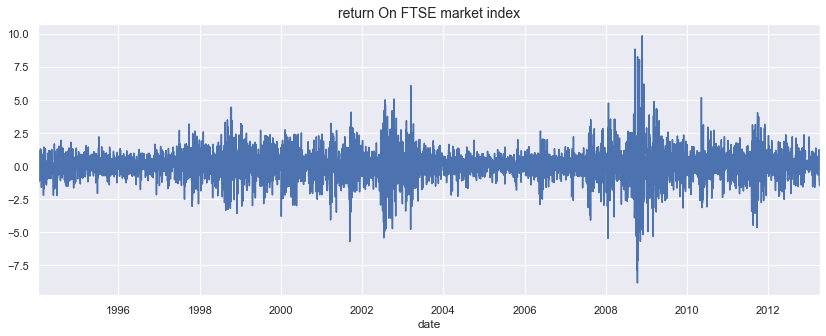

In [56]:
plt.rc('figure',figsize=(14,5))
df_market_value_train['return'].plot()
plt.title("return On FTSE market index",size=14)
plt.show()

### ***ACF and PACF Plot on Return***

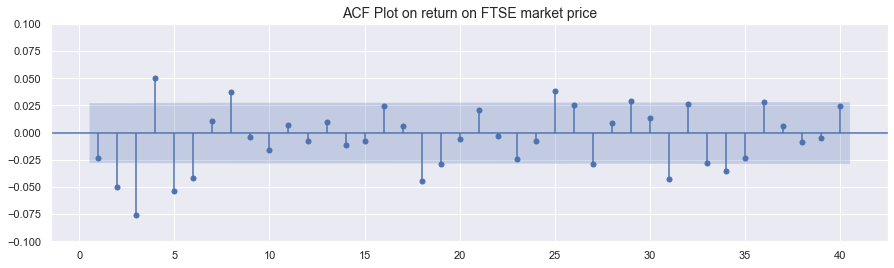

In [45]:
mpl.rc("figure", figsize=(15,4))
sgt.plot_acf(df_market_value_train['return'],lags=40,zero=False)
plt.title('ACF Plot on return on FTSE market price',size=14)
plt.ylim((-0.1, 0.1))
plt.show()

#### ***Observation***
- By observing ACF plot it is clear that upto lags 8 current return have significant correlation.
- Then from 9th lag to 17teen lag current return does not have significant correlation. Usually current return does not get affected by return gotten long before.
- It only slightly depend upon past certain period.
- But one thing also need to notice here that these correlation value has cyclic change with lag. it has negative correlation for first 3 lag then positive for 4th lag then again negative lag for 5th and 6th, then again positive. So this is what expected naturally cause price are driven by people buying and selling behaviour. And if price is high people sell to make profit which will lead decrease in price value and if price is low people buy stocks which eventually lead to increase in index price. it can be considered as natural adjustment. Same can be observed in the Pacf plot as well.
- Pacf plot also show same cyclic adjustment behaviour.
- But this pacf plot show direct correlation between current return and past return values.
- So for AR model development we will use significant lag obseved in Pacf plot.

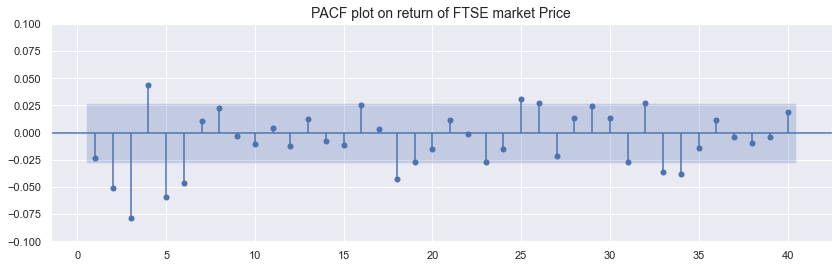

In [44]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train['return'],lags=40,zero=False,alpha=0.05,method='ols')
plt.title('PACF plot on return of FTSE market Price',size=14)
plt.ylim((-0.1,0.1))
plt.show()

### ***AutoRegression Modeling on Return Values***

#### AR1 model on return FTSE

In [55]:
model_ar1=ARIMA(df_market_value_train['return'],order=(1,0,0),freq='B')
result_ar1=model_ar1.fit()
print(result_ar1.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.756
Date:                Wed, 23 Oct 2024   AIC                          15865.512
Time:                        12:19:42   BIC                          15885.076
Sample:                    01-10-1994   HQIC                         15872.368
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.690      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.098      0.0

#### ***Observation***
- The coefficient-1 of AR1 model on FTSE Return is found out to be significant.
- But constant vaule is not significant form zero since p value greater than 0.05.
- but constant value supposed to be around zero becuase of natural adjustment that happened by people randomly.

In [46]:
def LLR_test(Model_a_res,Model_b_res,df=1):
    La=Model_a_res.llf
    Lb=Model_b_res.llf
    Q=2*(Lb-La)
    P=chi2.sf(Q,df)
    return P

#### ***AR2 Model on Ftse market index***

In [57]:
model_ar2=ARIMA(df_market_value_train['return'],order=(2,0,0),freq='B')
result_ar2=model_ar2.fit()
print(result_ar2.summary())
print('LLR test of AR1 and AR2',LLR_test(result_ar1,result_ar2))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.305
Date:                Wed, 23 Oct 2024   AIC                          15854.609
Time:                        12:35:34   BIC                          15880.694
Sample:                    01-10-1994   HQIC                         15863.749
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.232      -0.012       0.050
ar.L1         -0.0241      0.009     -2.794      0.005      -0.041      -0.007
ar.L2         -0.0507      0.008     -6.451      0.0

### ***Observation***
- AR2 model performed well.
- Coefficients-1 and 2 has significant value from zero.

#### ***AR3 model on FTSE return***

In [58]:
model_ar3=ARIMA(df_market_value_train['return'],order=(3,0,0),freq='B')
result_ar3=model_ar3.fit()
print(result_ar3.summary())
print('LLR test of AR2 and AR3',LLR_test(result_ar2,result_ar3))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7907.795
Date:                Wed, 23 Oct 2024   AIC                          15825.590
Time:                        12:39:02   BIC                          15858.196
Sample:                    01-10-1994   HQIC                         15837.016
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.269      0.205      -0.010       0.048
ar.L1         -0.0281      0.009     -3.184      0.001      -0.045      -0.011
ar.L2         -0.0526      0.008     -6.751      0.0

#### ***Observation***
- AR 3 performed well in comparision to AR2.
- all the coefficient are significantly different from zero.
- And all the coefficient value are negative it means that if return is more in past period then return will decrease in current period.

#### ***AR4 Model on FTSE Return***

In [59]:
model_ar4=ARIMA(df_market_value_train['return'],order=(4,0,0),freq='B')
result_ar4=model_ar4.fit()
print(result_ar4.summary())
print('LLR test of AR3 and AR4',LLR_test(result_ar3,result_ar4))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -7902.910
Date:                Wed, 23 Oct 2024   AIC                          15817.821
Time:                        12:43:39   BIC                          15856.948
Sample:                    01-10-1994   HQIC                         15831.531
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.208      0.227      -0.012       0.049
ar.L1         -0.0247      0.009     -2.790      0.005      -0.042      -0.007
ar.L2         -0.0503      0.008     -6.408      0.0

#### ***Observation***
- AR4 has performed significantly better in terms of log likelihood test.
- All cofficients are significant from zero and has negative values but 4th cofficients has positive values.

#### ***AR5 modeling on FTSE return***

In [60]:
model_ar5=ARIMA(df_market_value_train['return'],order=(5,0,0),freq='B')
result_ar5=model_ar5.fit()
print(result_ar5.summary())
print('LLR test of AR4 and AR5',LLR_test(result_ar4,result_ar5))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -7894.032
Date:                Wed, 23 Oct 2024   AIC                          15802.064
Time:                        12:50:26   BIC                          15847.712
Sample:                    01-10-1994   HQIC                         15818.060
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.273      0.203      -0.010       0.048
ar.L1         -0.0221      0.009     -2.431      0.015      -0.040      -0.004
ar.L2         -0.0549      0.008     -6.882      0.0

#### ***Observation***
- AR5 has performed well in the LLR test.
- In this model also all coefficient are significantly different from zero and negative except 4th lag.

#### ***Modeling AR6*** 

In [61]:
model_ar6=ARIMA(df_market_value_train['return'],order=(6,0,0),freq='B')
result_ar6=model_ar6.fit()
print(result_ar6.summary())
print('LLR test of AR5 and AR6',LLR_test(result_ar5,result_ar6))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7888.633
Date:                Wed, 23 Oct 2024   AIC                          15793.265
Time:                        12:56:40   BIC                          15845.435
Sample:                    01-10-1994   HQIC                         15811.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.323      0.186      -0.009       0.047
ar.L1         -0.0248      0.009     -2.672      0.008      -0.043      -0.007
ar.L2         -0.0529      0.008     -6.575      0.0

#### ***Observation***
- model AR6 has performed well llr test.
- all coefficient are significant. and negative except 4th 

#### ***AR7 Modeling on FTSE***

In [63]:
model_ar7=ARIMA(df_market_value_train['return'],order=(7,0,0),freq='B')
result_ar7=model_ar7.fit()
print(result_ar7.summary())
print('LLR test of AR6 and AR7',LLR_test(result_ar6,result_ar7))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -7888.363
Date:                Wed, 23 Oct 2024   AIC                          15794.726
Time:                        13:03:49   BIC                          15853.416
Sample:                    01-10-1994   HQIC                         15815.292
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.304      0.192      -0.010       0.047
ar.L1         -0.0243      0.009     -2.613      0.009      -0.043      -0.006
ar.L2         -0.0523      0.008     -6.449      0.0

#### ***Observation***
- AR6 has performed well in comparison to AR7
- all cofficient are significant from zero.
- all coefficient are negative except 4th and 7th.

#### ***AR8 Modeling on FTSE return***

In [64]:
model_ar8=ARIMA(df_market_value_train['return'],order=(8,0,0),freq='B')
result_ar8=model_ar8.fit()
print(result_ar8.summary())
print('LLR test of AR6 and AR8',LLR_test(result_ar6,result_ar8,2))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -7887.097
Date:                Wed, 23 Oct 2024   AIC                          15794.194
Time:                        13:04:58   BIC                          15859.406
Sample:                    01-10-1994   HQIC                         15817.045
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.264      0.206      -0.010       0.048
ar.L1         -0.0246      0.009     -2.619      0.009      -0.043      -0.006
ar.L2         -0.0512      0.008     -6.314      0.0

#### ***Observation***
- LLR test of model AR6 and AR8 has shown that model AR6 is still better.

#### ***MOdeling AR18 on FTSE return***
- Reason i have taken lag value 18 eventhough last well performed model was 6, because after 6th lag to 18th lag all pacf value are very insignigicant.
- that is also evident from llr test of model AR7 and AR8 with AR6.
- by observing Pacf plot of return we can see that after lag6, lag18 has significant pacf value.
- So AR18 is being Model here

In [65]:
model_ar18=ARIMA(df_market_value_train['return'],order=(18,0,0),freq='B')
result_ar18=model_ar18.fit()
print(result_ar18.summary())
print('LLR test of AR6 and AR18',LLR_test(result_ar6,result_ar18))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                ARIMA(18, 0, 0)   Log Likelihood               -7879.310
Date:                Wed, 23 Oct 2024   AIC                          15798.620
Time:                        13:10:19   BIC                          15929.043
Sample:                    01-10-1994   HQIC                         15844.322
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.0239      0.010     -2.434      0.015      -0.043      -0.005
ar.L2         -0.0498      0.008     -5.980      0.0

#### ***Observation***
- AR18 Model has performed significantly well from AR6.
- All the coefficient are signficantly different form zero.
- But since AR6 is very simple and AR18 are very complex and it may possible it will reach the overfit the state. So for simplicity we will chose Model AR6.

### ***Conclusion***
- We have transformed the FTSE market index price columns to find the return in each two consecutive period.
- Using return column for AR modeling is great choice cause AR model performed well staionary series.
- Here return series slightly behave as white noice because it has constant mean.
- And it is found out that AR6 has performed well in compared to all other model.
- In this model lag upto 6 has taken into the account for future return prediction.
- IN AR6 All the cofficient are significantly different from zero and negative except 4th coeffcient.
- It indicates that return will decrease and increase with increase and decrease respectively in past return at lag 1 to 3 and 5th to 6th.

## ***Normalizing Market Value columns***
- Normalizing return column with first value occuared in series.
- The reason we are normalizing the series cause it help algorithm to converge towards optimum value of coefficinet quickly.
- And i am also going to compare the return value in each market index(spx,dax,ftse,nikkei).
- but since avg return in nikkei is highest among others so by default nikkei will give better return but it is misleading.So we have to take a benchmark to compare the returns in each market index.

In [71]:
Benchmark=df_market_value_train['market_value'][0]
Benchmark

3440.58

In [78]:
df_market_value_train['norm_mar_val']=df_market_value_train['market_value'].div(Benchmark).mul(100)
df_market_value_train.head()

,market_value,wn,rw,return,norm_mar_val
date,,,,,
1994-01-10,3440.58,4653.269355,1080.347860,-0.156704,100.000000
1994-01-11,3413.77,5433.706888,1082.095245,-0.779229,99.220771
1994-01-12,3372.02,4927.120792,1083.639265,-1.222988,98.007313
1994-01-13,3360.01,4216.958605,1067.146255,-0.356166,97.658244
1994-01-14,3400.56,3507.310211,1080.129720,1.206842,98.836824


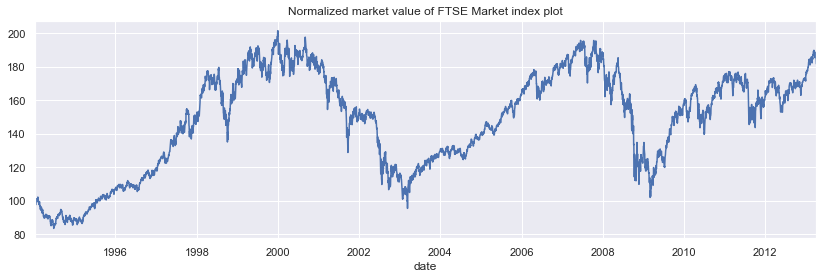

In [75]:
plt.rc('figure',figsize=(14,4))
df_market_value_train['norm_mar_val'].plot()
plt.title('Normalized market value of FTSE Market index plot')
plt.show()

In [80]:
adfuller(df_market_value_train['norm_mar_val'])

(-1.8936568624122199,
 0.33505098158646573,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19556.212836830156)

### ***Observation***
- The plot does not look like stationary graph.
- By Observing adfuller test on normalizing market value it is clear that it is not stationary.
- So we can't do AR modeling on this data.

## ***Normalizing on Return Column***
- We often rely on normalize return.
- They account for the abasolute profitability of the investment in contrast to price.
- They allow us compare relative profitability as opposed to non normalized return

In [81]:
Benchmark=df_market_value_train['return'][0]
Benchmark

-0.1567043337454055

In [82]:
df_market_value_train['norm_ret']=df_market_value_train['return'].div(Benchmark).mul(100)
df_market_value_train.head()

,market_value,wn,rw,return,norm_mar_val,norm_ret
date,,,,,,
1994-01-10,3440.58,4653.269355,1080.347860,-0.156704,100.000000,100.000000
1994-01-11,3413.77,5433.706888,1082.095245,-0.779229,99.220771,497.260711
1994-01-12,3372.02,4927.120792,1083.639265,-1.222988,98.007313,780.443046
1994-01-13,3360.01,4216.958605,1067.146255,-0.356166,97.658244,227.285567
1994-01-14,3400.56,3507.310211,1080.129720,1.206842,98.836824,-770.139292


### ***Dicky fuller test***

In [83]:
adfuller(df_market_value_train['norm_ret'])

(-12.786930957227389,
 7.213255047800831e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80118.5703598977)

#### ***Observation***
- dickyfuller test on normalized return value give the same statistics as same test on dickyfuller test.
- since p value is less than 0.05 so it is considered as stationary as regular return.

## ***AR modeling on normalized return of FTSE Index price***

### ***AR1 modeling on normalized returned value of FTSE index price***

In [84]:
model_ar1=ARIMA(df_market_value_train['return'],order=(1,0,0),freq='B')
result_ar1=model_ar1.fit()
print(result_ar1.summary())


C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7929.756
Date:                Wed, 23 Oct 2024   AIC                          15865.512
Time:                        15:33:11   BIC                          15885.076
Sample:                    01-10-1994   HQIC                         15872.368
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.143      0.253      -0.013       0.051
ar.L1         -0.0230      0.009     -2.690      0.007      -0.040      -0.006
sigma2         1.3790      0.014    100.098      0.0

### ***AR2 modeling on normalized returned value of FTSE index price***

In [85]:
model_ar2=ARIMA(df_market_value_train['return'],order=(2,0,0),freq='B')
result_ar2=model_ar2.fit()
print(result_ar2.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -7923.305
Date:                Wed, 23 Oct 2024   AIC                          15854.609
Time:                        15:34:48   BIC                          15880.694
Sample:                    01-10-1994   HQIC                         15863.749
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.194      0.232      -0.012       0.050
ar.L1         -0.0241      0.009     -2.794      0.005      -0.041      -0.007
ar.L2         -0.0507      0.008     -6.451      0.0

### ***AR6 modeling on normalized returned value of FTSE index price***

In [86]:
model_ar6=ARIMA(df_market_value_train['return'],order=(6,0,0),freq='B')
result_ar6=model_ar6.fit()
print(result_ar6.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -7888.633
Date:                Wed, 23 Oct 2024   AIC                          15793.265
Time:                        15:35:14   BIC                          15845.435
Sample:                    01-10-1994   HQIC                         15811.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.323      0.186      -0.009       0.047
ar.L1         -0.0248      0.009     -2.672      0.008      -0.043      -0.007
ar.L2         -0.0529      0.008     -6.575      0.0

#### ***Observation and Conclusion***
- By observing and comparing the coefficient of AR1, AR2 and AR6 modeled on normalized return, it is observed that coefficients value has converged to exact same value as it was for return.
- So normalizing the return does not affect coefficient values.
- In this case also AR6 is taken as best Model.

## ***Analysis of residual obtained from AR6 model for returned prediction of ftse market index***

In [87]:
df_market_value_train['resid_ret']=result_ar6.resid.values

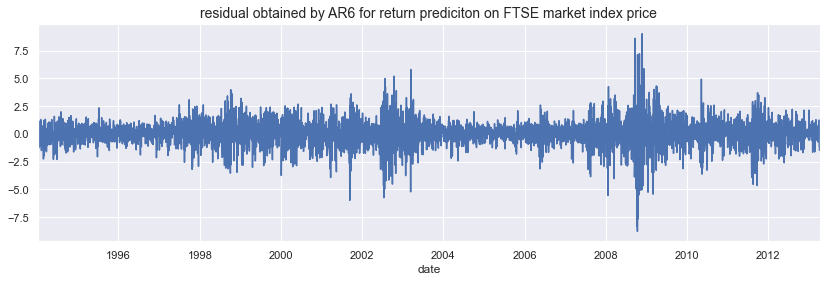

In [90]:
plt.figure(figsize=(14,4))
df_market_value_train.resid_ret.plot()
plt.title('residual obtained by AR6 for return prediciton on FTSE market index price',size=14)
plt.show()

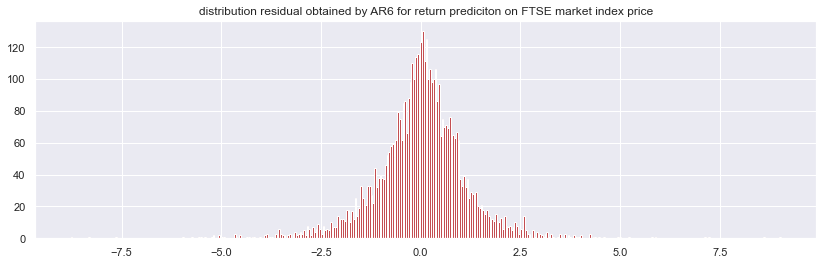

In [94]:
plt.figure(figsize=(14,4))
df_market_value_train.resid_ret.hist(bins=400,color='r')
plt.title('distribution residual obtained by AR6 for return prediciton on FTSE market index price')
plt.show()

In [95]:
mean=df_market_value_train['resid_ret'].mean()
std=df_market_value_train['resid_ret'].std()
mean,std

(-4.825353904588571e-05, 1.1648573288886448)

In [97]:
ci=norm.interval(alpha=0.997,loc=mean,scale=std)
ci

(-3.4570395260942037, 3.456943019016099)

#### ***Adfuller Test***

In [98]:
adfuller(df_market_value_train.resid_ret)

(-70.78594469484374,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15695.929509316542)

#### ***Pacf and ACf plot of the resid obtained from AR6 Model prediction of FTSE market index return***

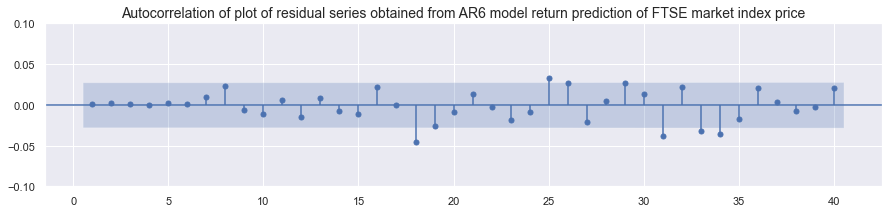

In [101]:
plt.rc('figure',figsize=(15,3))
sgt.plot_acf(df_market_value_train.resid_ret,zero=False,lags=40)
plt.title('Autocorrelation of plot of residual series obtained from AR6 model return prediction of FTSE market index price',size=14)
plt.ylim((-0.1,0.1))
plt.show()

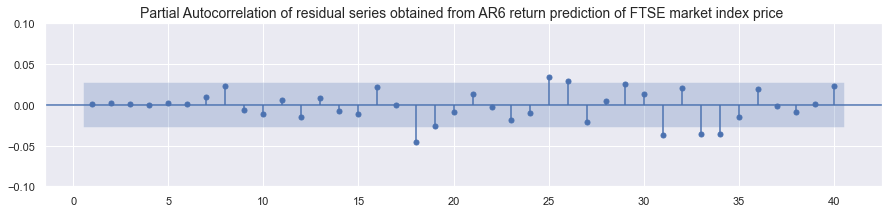

In [103]:
plt.rc('figure',figsize=(15,3))
sgt.plot_pacf(df_market_value_train.resid_ret,lags=40,zero=False,method='ols')
plt.title('Partial Autocorrelation of residual series obtained from AR6 return prediction of FTSE market index price ',size=14)
plt.ylim((-0.1,0.1))
plt.show()

#### ***Observation and Conclusion***
- adfuller test says that residual obtained from AR6 model return prediction, is a stationary series.
- series has (mean,std)=(-4.825353904588571e-05, 1.1648573288886448)
- It is observed from pacf and acf plot that each current residual has negligible correlation with all previous residual.
- So this residual correlation can considered as white noice.
- since all white noice resemble with normal distribution.
- It is also evident from distribution plot and time series plot of the residuals.
  
***Conclusion***

- 99.7 percent confidence interval around mean has been found out to be (-3.4570395260942037, 3.456943019016099).
- It means that 99.7 percent of times people will get return in between -3.45 to 3.45, if they invest money on this ftse market index by relying on AR6 model.